In [0]:
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision as tv
import torchvision.models as models
from PIL import Image
import glob
import os
import time
from torch.optim import lr_scheduler
import copy
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.nn.modules import Module
import torchvision.models.vgg as tv_vgg
import torchvision.transforms as transforms
import torch.utils.model_zoo as model_zoo
import math
from torch.nn import functional as F
from torch.nn.modules.utils import _pair as pair
from torch.nn.parameter import Parameter
from torch.nn import init


# Computation Routines

## Load data

In [0]:
class DatasetManager:
    
    def __init__(self, dataset = 'cifar10', percent_data = 10.0, percent_val = 20.0, data_path = './data'):
        
        # 'dataset' can be 'hymenoptera', 'cifar10', or 'cifar100'.
        # 'percent_data' is the percentage of the full training set to be used.
        # 'percent_val' is the percentage of the *loaded* training set to be used as validation data.
        
        self.dataset = dataset
        self.data_path = data_path
        self.percent_data = percent_data
        self.percent_val = percent_val
        
        if self.dataset == 'hymenoptera':

            self.transform = tv.transforms.Compose([
                tv.transforms.RandomResizedCrop(224),
                tv.transforms.RandomHorizontalFlip(),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
            
        elif self.dataset == 'cifar10' or self.dataset == 'cifar100':

            self.transform = tv.transforms.Compose([
                tv.transforms.RandomResizedCrop(224),
                tv.transforms.RandomHorizontalFlip(),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        return
    
    
    def ImportDataset(self, batch_size=5):
        
        self.batch_size = batch_size
        
        if self.dataset == 'hymenoptera':
        
            self.trainset = tv.datasets.ImageFolder(root=self.data_path,
                             transform=self.transform)
        
        # todo
        
        elif self.dataset == 'cifar10':

            self.trainset = tv.datasets.CIFAR10(root=self.data_path, train=True,
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.CIFAR10(root=self.data_path, train=False,
                                       download=True, transform=self.transform)
        
        elif self.dataset == 'cifar100':

            self.trainset = tv.datasets.CIFAR100(root=self.data_path, train=True,
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.CIFAR100(root=self.data_path, train=False,
                                       download=True, transform=self.transform)
             
        self.SplitData();
        self.GenerateLoaders();
                
        return
    
    
    def SplitData(self):
        
        len_full = self.trainset.__len__()
        len_train = int(np.round(len_full*self.percent_data/100.0))
        
        _, self.trainset = torch.utils.data.random_split(self.trainset, (len_full-len_train, len_train))
        
        len_val = int(np.round(len_train*self.percent_val/100.0))
        len_train = len_train - len_val
        
        self.valset, self.trainset = torch.utils.data.random_split(self.trainset, (len_val, len_train))
         
        len_full_test = self.testset.__len__()
        len_test = int(np.round(len_full_test*self.percent_data/100.0))
        
        _, self.testset = torch.utils.data.random_split(self.testset, (len_full_test-len_test, len_test))

        print('\nFull training set size: {}'.format(len_full))
        print('Full test set size: {}'.format(len_full_test))
        print('\nActive training set size: {}'.format(len_train))
        print('Active validation set size: {}'.format(len_val))
        print('Active test set size: {}\n'.format(len_test))
        
        return
    
    
    def GenerateLoaders(self):
        
        self.train_loader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)
        self.val_loader = torch.utils.data.DataLoader(self.valset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)
        self.test_loader = torch.utils.data.DataLoader(self.testset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)          
            
        return
    

## Training functions

In [0]:
def RecordLosses(phase, epoch_loss, epoch_acc, prune_settings):
    
    # Record losses for later use, plotting etc
    if phase == 'train':
        prune_settings.epoch_loss.append(epoch_loss)
        prune_settings.epoch_acc.append(epoch_acc)
    elif phase == 'val':
        prune_settings.val_loss.append(epoch_loss)
        prune_settings.val_acc.append(epoch_acc)

    return prune_settings


def PlotResults(prune_settings):
    
    # ====== Plot ======

    # ------ Loss ------

    plt.figure()
    plt.plot(np.arange(1, len(prune_settings.epoch_loss)+1), 
             prune_settings.epoch_loss, 
             color='red', 
             marker='',  markersize=12, 
             linestyle='-', linewidth=2,
             label='Epoch loss')
    plt.plot(np.arange(1, len(prune_settings.val_loss)+1), 
             prune_settings.val_loss, 
             color='blue', 
             marker='',  markersize=12, 
             linestyle='-', linewidth=2,
             label='Validation loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    # ------ Accuracy ------

    plt.figure()
    plt.plot(np.arange(1, len(prune_settings.epoch_acc)+1), 
             np.asarray(prune_settings.epoch_acc)*100.0, 
             color='red', 
             marker='',  markersize=12, 
             linestyle='-', linewidth=2,
             label='Epoch accuracy')
    plt.plot(np.arange(1, len(prune_settings.val_acc)+1), 
             np.asarray(prune_settings.val_acc)*100.0, 
             color='blue', 
             marker='',  markersize=12, 
             linestyle='-', linewidth=2,
             label = 'Validation accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.grid()
    plt.legend()

    return


def SaveResults(prune_settings, model):
    
    
    
    return


def train_model(model, dat, criterion, optimizer, scheduler, prune_settings=0, num_epochs=25):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                scheduler.step()
                dataloader = dat.train_loader
                dataset_size = dat.trainset.__len__()
                
                model.train()  # Set model to training mode
                
            else:
                
                model.eval()   # Set model to evaluate mode
                dataloader = dat.val_loader
                dataset_size = dat.valset.__len__()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if prune_settings != 0:
                    TrackConv2DNorms(model, prune_settings, inputs)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            # Record losses for later use, plotting etc
            prune_settings = RecordLosses(phase, epoch_loss, epoch_acc, prune_settings)


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Record losses for later use, plotting etc
    prune_settings.outer_iter_time.append(time_elapsed)
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model


## Pruning functions

### Pruning settings

In [0]:

# Constants that define possible pruning metrics
WEIGHT_NORM = 1
ACT_NORM = 2

# Class that contains various settings pertaining to how filters are pruned
class UnitPruningSettings:
    
    def __init__(self, idx_layer=0, idx_filter=0, N_prune=1, P_prune=10, p=2, pruning_metric=WEIGHT_NORM):
        
        # EITHER N_prune OR P_prune will be used to decide how many filters to prune.
        # If one is non-positive, the other is used.
        # If neither is non-positive, priority is given to P_prune.
        # If both are non-positive, no pruning will happen.

        self.N_prune = N_prune # Number of filters allowed to be pruned in one pass
        self.P_prune = P_prune; # Percent of filters of the current layer to prune
        
        self.idx_filter = idx_filter # Indices of the N_prune filters
        self.idx_layer = idx_layer # Current layer under consideration
        self.p = p # p-norm to use when computing which filters to remove
        self.pruning_metric = pruning_metric
        
        self.norms_botk = []
        self.idx_norms_botk = []
        
        # Various statistics will be stored and computed to keep track of how the network changes
        
        # Number of filters per layer in the original network
        self.filters_per_layer_orig = []
        
        # Number of filters per layer after pruning - this gets updated every time the network is pruned
        self.filters_per_layer_after = []
        
        # Time taken to prune in sec (running total, updated every time pruning happens)
        self.prune_time = 0.0
        self.outer_iter_time = []
        
        # Keep track of running epoch loss and validation loss, and corresponding accuracy
        self.epoch_loss = []
        self.val_loss = []
        self.epoch_acc = []
        self.val_acc = []
        
        return
    
    # Function to print the current pruning state of the model. Verbose can be 0, 1, or 2.
    def PrintPruningStatistics(self, verbose=1):
    
        if verbose == 0:
            return
        
        print("Total number of filters before pruning: {}".format(sum(self.filters_per_layer_orig)))
        print("Total number of filters after pruning: {}".format(sum(self.filters_per_layer_after)))
    
        return
    
    # Function to set up and initialize based on a given model
    def Setup(self, model):
        
        # Count the number of conv layers
        self.N_layers = 0
        
        for layer, (name, module) in enumerate(model.features._modules.items()):
            self.N_layers += 1
                    
        # Initialize storage containers
        self.norms_botk = [None]*self.N_layers
        self.idx_norms_botk = [None]*self.N_layers
        
    
    # Function to reset norm containers
    def ResetNormContainers(self):
    
        self.norms_botk = [None]*self.N_layers
        self.idx_norms_botk = [None]*self.N_layers
    
        return

    # Function to reset filter containers
    def ResetFilterContainers(self):
    
        self.filters_per_layer_orig = []
        self.filters_per_layer_after = []
    
        return

        




### Pruning decisions

In [0]:
# Function to compute the p-norm of weights in all filters of a given layer.
# The list of norms are returned in a list in the same order as that in which filters of that layer are stored.
def ComputeConv2DWeightNorms(model, idx_layer, p):
    
    # Extract the layer of the model currently being considered
    _, conv = list(model.features._modules.items())[idx_layer]
    weights = conv.weight.data

    # Compute norms of each filter
    norms = weights.norm(p, dim=2).norm(p, dim=2).norm(p, dim=1)
    
    return norms


# Function to compute the p-norm of activations in all filters per layer.
# The list of norms are returned in a list in the same order as that in which filters of that layer are stored.
def ComputeConv2DActNorms(activation, prune_settings):
    
    p = prune_settings.p
    
    # Compute norms of each activation
    norms = torch.norm(activation, p, dim=0).norm(p, dim=1).norm(p, dim=1)
        
    return norms


# Function to track the p-norm of activations of all filters of during training.
def TrackConv2DNorms(model, prune_settings, inputs):
    
    p = prune_settings.p
    P_prune = prune_settings.P_prune

    x = Variable(inputs)

    ii = -1
    for layer, (name, module) in enumerate(model.features._modules.items()):
        ii += 1
        x = module(x)
        
        if isinstance(module, torch.nn.modules.conv.Conv2d):
            
            if prune_settings.pruning_metric == WEIGHT_NORM:
                norms = ComputeConv2DWeightNorms(model, ii, p)
            elif prune_settings.pruning_metric == ACT_NORM:
                norms = ComputeConv2DActNorms(x, prune_settings)

            # Use the given prune percentage to figure out how many filters to prune
            if (P_prune >= 0):
                N_prune = int(len(norms.float())*P_prune/100.0)
                prune_settings.N_prune = N_prune

#             n_botk, ind_botk = torch.topk(norms, N_prune, 0, largest=False, sorted=True, out=None)
            norms = norms.cpu().detach().numpy()
    
            # Store the norms for each filter
#             if prune_settings.norms_botk[ii] is None:
#                 prune_settings.norms_botk[ii] = norms
#             else:
#                 prune_settings.norms_botk[ii] += norms
                
            # Store normalized norms for each filter
            if prune_settings.norms_botk[ii] is None:
                prune_settings.norms_botk[ii] = norms/max(norms)
            else:
                prune_settings.norms_botk[ii] += norms/max(norms)
                
    return

### Pruning workers

In [0]:
# The following functions were adapted from https://github.com/jacobgil/pytorch-pruning/blob/master/prune.py

def replace_layers(model, i, idx, layers):
	if i in idx:
		return layers[idx.index(i)]
	return model[i]


# Function to prune a given convolution layer in the model provided.
# Input "idx_layers" is the global index of the convolution layer to be pruned.
# Input "prune_settings" is a data structure containing information on how pruning is performed.
def PruneConvLayers(model, prune_settings):
    
    # Strategy: in order to prune a particular layer, the output of the previous layer 
    # and the inputs to the next layer must also be altered accordingly.
	
    # Extract pruning settings for convenience
    N_prune = prune_settings.N_prune
    idx_filter = prune_settings.idx_filter
    idx_layer = prune_settings.idx_layer
    
    if idx_layer >= len(model.features._modules.items()):
        return
        
    # Extract the layer of the model currently being pruned
    _, conv = list(model.features._modules.items())[idx_layer]
    

    # In case the list of target filters to delete has out-of-range entries, detect and ignore them
    del_filters = []
    for kk in range(0, len(idx_filter)):
        if idx_filter[kk] >= conv.out_channels:
            del_filters.extend(kk)
    
    if (len(del_filters) > 0):
        idx_filter = np.delete(idx_filter, del_filters, 0)
        N_prune = len(idx_filter)
        prune_settings.N_prune = N_prune
        print("[WARNING] Encountered an out-of-range target filter; it will be ignored.")
    
    # Record pruning statistics
    prune_settings.filters_per_layer_orig[idx_layer] = conv.out_channels
    prune_settings.filters_per_layer_after[idx_layer] = conv.out_channels - N_prune
    
        
    # To keep track of the succeeding convolution layer
    next_conv = None
    offset = 1
    
    # Figure out how many layers after this one are NOT conv layers, in order to skip pruning them
    while idx_layer + offset < len(model.features._modules.items()):
        
        res =  list(model.features._modules.items())[idx_layer + offset]
        if isinstance(res[1], torch.nn.modules.conv.Conv2d):
            next_name, next_conv = res
            break
        offset = offset + 1
    
    # Create a new, replacement conv layer to remove a given number of filters.
    # The rest of its settings should remain the same as the original conv layer.
    new_conv = torch.nn.Conv2d(in_channels = conv.in_channels,
                               out_channels = conv.out_channels - N_prune,
			                   kernel_size = conv.kernel_size,
                               stride = conv.stride,
                               padding = conv.padding,
                               dilation = conv.dilation,
                               groups = conv.groups,
                               bias = True)
    
    new_conv.bias = conv.bias
    
    # Copy over the weights to the new conv layer, except the ones corresponding to the filter to be removed
    old_weights = conv.weight.data.cpu().numpy()
    new_weights = new_conv.weight.data.cpu().numpy()
    
    # Copy over the set of filters, excluding the ones to be removed
    new_weights_temp = np.copy(old_weights)
    new_weights_temp = np.delete(new_weights_temp, idx_filter, 0)
    new_weights[:, :, :, :] = new_weights_temp[:, :, :, :]

    # Update weight data of the new conv layer
    new_conv.weight.data = torch.from_numpy(new_weights).cuda()
    
    # Now do the same thing for biases
    old_biases = conv.bias.data.cpu().numpy()
    new_biases = np.zeros(shape=(old_biases.shape[0] - N_prune), dtype=np.float32)
    
    new_biases_temp = np.copy(old_biases)
    new_biases_temp = np.delete(new_biases_temp, idx_filter, 0)
    new_biases[:] = new_biases_temp[:]
        
    new_conv.bias.data = torch.from_numpy(new_biases).cuda()
    
    # If there is a succeeding conv layer, adjust its input units and weights accordingly
    if next_conv != None:
        
        next_new_conv = torch.nn.Conv2d(in_channels = next_conv.in_channels - N_prune,
                                        out_channels =  next_conv.out_channels,
                                        kernel_size = next_conv.kernel_size,
                                        stride = next_conv.stride,
                                        padding = next_conv.padding,
                                        dilation = next_conv.dilation,
                                        groups = next_conv.groups,
                                        bias = True)
        
        next_new_conv.bias = next_conv.bias

        old_weights = next_conv.weight.data.cpu().numpy()
        new_weights = next_new_conv.weight.data.cpu().numpy()
        
        # Copy over the set of filters, excluding the ones to be removed
        new_weights_temp = np.copy(old_weights)
        new_weights_temp = np.delete(new_weights_temp, idx_filter, 1)
        new_weights[:, :, :, :] = new_weights_temp[:, :, :, :]

        next_new_conv.weight.data = torch.from_numpy(new_weights).cuda()

        # Now do the same thing for biases
        next_new_conv.bias.data = next_conv.bias.data

        # Update the actual model by replacing the existing filters with the new ones
        features = torch.nn.Sequential(
                *(replace_layers(model.features, i, [idx_layer, idx_layer + offset], \
                    [new_conv, next_new_conv]) for i, _ in enumerate(model.features)))
        del model.features
        del conv

        model.features = features
    
    else:

        # This is the last conv layer. This affects the first linear layer of the classifier.
        model.features = torch.nn.Sequential(*(replace_layers(model.features, i, [idx_layer], [new_conv]) for i, _ in enumerate(model.features)))
        idx_layer = 0
        old_linear_layer = None

        for _, module in model.classifier._modules.items():
            if isinstance(module, torch.nn.Linear):
                old_linear_layer = module
                break
            idx_layer = idx_layer + 1

        if old_linear_layer == None:
            raise BaseException("No linear layer found in classifier.")
            
        params_per_input_channel = int(old_linear_layer.in_features/conv.out_channels)

        new_linear_layer = torch.nn.Linear(old_linear_layer.in_features - N_prune*params_per_input_channel, 
                                           old_linear_layer.out_features)

        old_weights = old_linear_layer.weight.data.cpu().numpy()
        new_weights = new_linear_layer.weight.data.cpu().numpy()	 	

        # Copy over the set of filters, excluding the ones to be removed
        new_weights_temp = np.copy(old_weights)
        idx_expanded = np.zeros(shape=(N_prune*params_per_input_channel))
        
        for kk in range(0, len(idx_filter)):
            idx_expanded[kk*params_per_input_channel:kk*params_per_input_channel+params_per_input_channel] = np.arange(idx_filter[kk]*params_per_input_channel, idx_filter[kk]*params_per_input_channel + params_per_input_channel)

        new_weights_temp = np.delete(new_weights_temp, idx_expanded.astype(int), 1)
        new_weights[:, :] = new_weights_temp[:, :]
        
        new_linear_layer.bias.data = old_linear_layer.bias.data
        new_linear_layer.weight.data = torch.from_numpy(new_weights).cuda()

        classifier = torch.nn.Sequential(*(replace_layers(model.classifier, i, [idx_layer], [new_linear_layer]) for i, _ in enumerate(model.classifier)))

        del model.classifier
        del next_conv
        del conv
        model.classifier = classifier
        
    return model


### Pruning driver

In [0]:
# Function to iterate through all conv2D layers of the network and determine 
# filters to be pruned, and then carry out the pruning.
def PruneAllConv2DLayers(model, prune_settings):
    
    # Extract pruning settings for convenience
    # Note that "N_prune" *consecutive* filters will get pruned
    N_prune = prune_settings.N_prune
    P_prune = prune_settings.P_prune
    p = prune_settings.p
    pruning_metric = prune_settings.pruning_metric
    
    # Count number of prunable layers for preallocation
    N_layers = len(model.features._modules.items())       
    prune_settings.filters_per_layer_orig = np.zeros(shape=(1, N_layers)).ravel()
    prune_settings.filters_per_layer_after = np.zeros(shape=(1, N_layers)).ravel()

    
    # Find the N_prune filters to remove
    ii = 0
    while ii < len(model.features._modules.items()):
        
        res = list(model.features._modules.items())[ii]
        
        if isinstance(res[1], torch.nn.modules.conv.Conv2d):
            
            _, conv = list(model.features._modules.items())[ii]
            
            # Record pruning statistics
            prune_settings.filters_per_layer_orig[ii] = conv.out_channels
            prune_settings.filters_per_layer_after[ii] = conv.out_channels
            
            # Compute values and indices of the N_prune smallest norms
#             if pruning_metric == WEIGHT_NORM:
#                 norms = ComputeConv2DWeightNorms(model, ii, p)
#             elif pruning_metric == ACT_NORM:
# #                 norms = ComputeConv2DWeightNorms(model, ii, p)
#                 norms = ComputeConv2DActNorms(res[1], prune_settings)
                
        
            if (P_prune >= 0):
                N_prune = int(conv.out_channels*P_prune/100.0)
                prune_settings.N_prune = N_prune
            
            if prune_settings.norms_botk[ii] is not None:
                
#                 n_botk, ind_botk = torch.topk(torch.from_numpy(prune_settings.norms_botk[ii]), N_prune, 0, largest=False, sorted=True, out=None)
            
                norms = np.asarray(prune_settings.norms_botk[ii]).ravel()
                ind_botk = np.argpartition(norms, N_prune)    
                n_botk = norms[ind_botk[:N_prune]]
                ind_botk = ind_botk[:N_prune]
        
                prune_settings.idx_layer = ii
                prune_settings.idx_filter = ind_botk

                model = PruneConvLayers(model, prune_settings)
                
        ii = ii + 1
            
    return model


## Test Pruning

In [8]:
# Test pruning

model = models.vgg16(pretrained=True)
model.train()

# Pruning setup
prune_settings = UnitPruningSettings(idx_layer=28, idx_filter=(10, 12, 15, 16, 21), 
                                     N_prune=5, p=2, pruning_metric=WEIGHT_NORM)
# prune_settings = UnitPruningSettings(idx_layer=28, idx_filter=(10), 
#                                      N_prune=1, p=2, pruning_metric=WEIGHT_NORM)

N_layers = len(model.features._modules.items())       
prune_settings.filters_per_layer_orig = np.zeros(shape=(1, N_layers)).ravel()
prune_settings.filters_per_layer_after = np.zeros(shape=(1, N_layers)).ravel()

t0 = time.time()
model = PruneConvLayers(model, prune_settings)
print ("Pruning took {} s".format(time.time() - t0))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:05, 109909910.43it/s]


Pruning took 13.103468179702759 s


# Meta-Pruning Functions

In [0]:
class Masked:
    def make_mask(self, threshold, mask=None):
        if mask is None:
            print("new mask", device)
            self.mask = torch.ones(self.weight.size(), requires_grad=False).to(device)
        else:
            self.mask = mask      
        self.zeros = torch.zeros(self.weight.size(), requires_grad=False).to(device)
        self.threshold = threshold
    
    def set_threshold(self, prop=0.05):
        unique_weights = torch.unique(self.weight*self.mask)
        mask_size = self.mask.reshape(-1).size()[0]
#     mask_size = mask_size[0]*mask_size[1]
        mask_nonzero = torch.sum(self.mask.view([mask_size]))
        mask_total = mask_size
        print('nonzero proportion: {:.4f}'.format(mask_nonzero/mask_total))
        self.threshold = torch.max(torch.topk(torch.abs(unique_weights),int(prop*unique_weights.size()[0]),largest=False)[0])    

    def make_threshold_mask(self):
        self.mask = torch.where(torch.abs(self.weight) >= self.threshold,self.mask,self.zeros).to(device)
#     self.mask.requires_grad_(requires_grad=False)
    def mask_weight(self):
        self.weight = torch.nn.Parameter(self.weight*self.mask).to(device)
    
class MaskedLinear(torch.nn.Linear, Masked):
    def __init__(self, in_features, out_features, bias=True, threshold=0.001, mask=None):
        super(MaskedLinear, self).__init__(in_features,out_features)
        self.make_mask(threshold,mask)
    def forward(self, input):
        self.make_threshold_mask()
        self.mask_weight()
        #     print(self.mask[125:135,125:135])
        #     print(self.weight[125:135,125:135])
        return F.linear(input, self.weight, self.bias)

class MaskedConv(torch.nn.Conv2d, Masked):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias=True, threshold=0.0001):
        super(MaskedConv,self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.make_mask(threshold)    
    def forward(self, input):
        self.mask_weight()
        return F.conv2d(input, self.weight, self.bias, self.stride,
                    self.padding, self.dilation, self.groups)

limit_a, limit_b, epsilon = -.1, 1.1, 1e-6
device='cuda'

class LinearL0(Module):
    """Implementation of L0 regularization for the input units of a fully connected layer"""
    def __init__(self, in_features, out_features, bias=True, weight_decay=1., droprate_init=0.5, temperature=2./3.,
                 lamba=1., local_rep=False, **kwargs):
        """
        :param in_features: Input dimensionality
        :param out_features: Output dimensionality
        :param bias: Whether we use a bias
        :param weight_decay: Strength of the L2 penalty
        :param droprate_init: Dropout rate that the L0 gates will be initialized to
        :param temperature: Temperature of the concrete distribution
        :param lamba: Strength of the L0 penalty
        :param local_rep: Whether we will use a separate gate sample per element in the minibatch
        """
        super(LinearL0, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.prior_prec = weight_decay
        self.weights = torch.nn.Parameter(torch.Tensor(in_features, out_features).to(device))
        #         self.qz_loga = torch.Tensor(in_features).to(device)
        self.qz_loga = torch.nn.Parameter(torch.Tensor(in_features).to(device))
        self.temperature = temperature
        self.droprate_init = droprate_init if droprate_init != 0. else 0.5
        self.lamba = lamba
        self.use_bias = False
        self.local_rep = local_rep
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
            self.use_bias = True
        self.floatTensor = torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor
        self.reset_parameters()
        
        
    def reset_parameters(self):
        torch.nn.init.kaiming_normal(self.weights, mode='fan_out')

        self.qz_loga.data.normal_(math.log(1 - self.droprate_init) - math.log(self.droprate_init), 1e-2)

        if self.use_bias:
            self.bias.data.fill_(0)

    def constrain_parameters(self, **kwargs):
        self.qz_loga.data.clamp_(min=math.log(1e-2), max=math.log(1e2))

    def cdf_qz(self, x):
        """Implements the CDF of the 'stretched' concrete distribution"""
        xn = (x - limit_a) / (limit_b - limit_a)
        logits = math.log(xn) - math.log(1 - xn)
        return F.sigmoid(logits * self.temperature - self.qz_loga).clamp(min=epsilon, max=1 - epsilon).to(device)

    def quantile_concrete(self, x):
        """Implements the quantile, aka inverse CDF, of the 'stretched' concrete distribution"""
        y = F.sigmoid((torch.log(x) - torch.log(1 - x) + self.qz_loga) / self.temperature).to(device)
        return y * (limit_b - limit_a) + limit_a

    def _reg_w(self):
        """Expected L0 norm under the stochastic gates, takes into account and re-weights also a potential L2 penalty"""
        logpw_col = torch.sum(- (.5 * self.prior_prec * self.weights.pow(2)) - self.lamba, 1).to(device)
        logpw = torch.sum((1 - self.cdf_qz(0)) * logpw_col).to(device)
        logpb = 0 if not self.use_bias else - torch.sum(.5 * self.prior_prec * self.bias.pow(2)).to(device)
        return logpw + logpb
        
        
    def regularization(self):
        return self._reg_w()

    def count_expected_flops_and_l0(self):
        """Measures the expected floating point operations (FLOPs) and the expected L0 norm"""
        # dim_in multiplications and dim_in - 1 additions for each output neuron for the weights
        # + the bias addition for each neuron
        # total_flops = (2 * in_features - 1) * out_features + out_features
        ppos = torch.sum(1 - self.cdf_qz(0))
        expected_flops = (2 * ppos - 1) * self.out_features
        expected_l0 = ppos * self.out_features
        if self.use_bias:
            expected_flops += self.out_features
            expected_l0 += self.out_features
#       return expected_flops.data[0], expected_l0.data[0]
        return expected_flops, expected_l0

    def get_eps(self, size):
        """Uniform random numbers for the concrete distribution"""
        eps = self.floatTensor(size).uniform_(epsilon, 1-epsilon).to(device)
        eps = Variable(eps)
        return eps

    def sample_z(self, batch_size, sample=True):
        """Sample the hard-concrete gates for training and use a deterministic value for testing"""
        if sample:
            eps = self.get_eps(self.floatTensor(batch_size, self.in_features).to(device))
            z = self.quantile_concrete(eps)
            return F.hardtanh(z, min_val=0, max_val=1).to(device)
        else:  # mode
            pi = F.sigmoid(self.qz_loga).view(1, self.in_features).expand(batch_size, self.in_features).to(device)
            return F.hardtanh(pi * (limit_b - limit_a) + limit_a, min_val=0, max_val=1).to(device)
        
    def sample_weights(self):
        z = self.quantile_concrete(self.get_eps(self.floatTensor(self.in_features).to(device)))
        mask = F.hardtanh(z, min_val=0, max_val=1).to(device)
        return mask.view(self.in_features, 1) * self.weights

    def forward(self, input):
        if self.local_rep or not self.training:
            z = self.sample_z(input.size(0), sample=self.training)
            xin = input.mul(z)
            output = xin.mm(self.weights)
        else:
            weights = self.sample_weights()
            output = input.mm(weights)
        if self.use_bias:
            output.add_(self.bias)
        return output

    def __repr__(self):
        s = ('{name}({in_features} -> {out_features}, droprate_init={droprate_init}, '
            'lamba={lamba}, temperature={temperature}, weight_decay={prior_prec}, '
            'local_rep={local_rep}')
        if not self.use_bias:
            s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)

In [0]:
class L0Conv2d(Module):
    """Implementation of L0 regularization for the feature maps of a convolutional layer"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True,
                 droprate_init=0.5, temperature=2./3., weight_decay=1., lamba=1., local_rep=False, **kwargs):
        """
        :param in_channels: Number of input channels
        :param out_channels: Number of output channels
        :param kernel_size: Size of the kernel
        :param stride: Stride for the convolution
        :param padding: Padding for the convolution
        :param dilation: Dilation factor for the convolution
        :param groups: How many groups we will assume in the convolution
        :param bias: Whether we will use a bias
        :param droprate_init: Dropout rate that the L0 gates will be initialized to
        :param temperature: Temperature of the concrete distribution
        :param weight_decay: Strength of the L2 penalty
        :param lamba: Strength of the L0 penalty
        :param local_rep: Whether we will use a separate gate sample per element in the minibatch
        """
        super(L0Conv2d, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = pair(kernel_size)
        self.stride = pair(stride)
        self.padding = pair(padding)
        self.dilation = pair(dilation)
        self.output_padding = pair(0)
        self.groups = groups
        self.prior_prec = weight_decay
        self.lamba = lamba
        self.droprate_init = droprate_init if droprate_init != 0. else 0.5
        self.temperature = temperature
        self.floatTensor = torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor
        self.use_bias = False
        self.weights = Parameter(torch.Tensor(out_channels, in_channels // groups, *self.kernel_size).to(device))
        self.qz_loga = Parameter(torch.Tensor(out_channels).to(device))
        self.dim_z = out_channels
        self.input_shape = None
        self.local_rep = local_rep

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels).to(device))
            self.use_bias = True

        self.reset_parameters()
        print(self)

    def reset_parameters(self):
        init.kaiming_normal(self.weights, mode='fan_in')

        self.qz_loga.data.normal_(math.log(1 - self.droprate_init) - math.log(self.droprate_init), 1e-2)

        if self.use_bias:
            self.bias.data.fill_(0)

    def constrain_parameters(self, **kwargs):
        self.qz_loga.data.clamp_(min=math.log(1e-2), max=math.log(1e2))

    def cdf_qz(self, x):
        """Implements the CDF of the 'stretched' concrete distribution"""
        xn = (x - limit_a) / (limit_b - limit_a)
        logits = math.log(xn) - math.log(1 - xn)
        return F.sigmoid(logits * self.temperature - self.qz_loga).clamp(min=epsilon, max=1 - epsilon)

    def quantile_concrete(self, x):
        """Implements the quantile, aka inverse CDF, of the 'stretched' concrete distribution"""
        y = F.sigmoid((torch.log(x) - torch.log(1 - x) + self.qz_loga) / self.temperature)
        return y * (limit_b - limit_a) + limit_a

    def _reg_w(self):
        """Expected L0 norm under the stochastic gates, takes into account and re-weights also a potential L2 penalty"""
        q0 = self.cdf_qz(0)
        logpw_col = torch.sum(- (.5 * self.prior_prec * self.weights.pow(2)) - self.lamba, 3).sum(2).sum(1)
        logpw = torch.sum((1 - q0) * logpw_col).to(device)
        logpb = 0 if not self.use_bias else - torch.sum((1 - q0) * (.5 * self.prior_prec * self.bias.pow(2) -
                                                                    self.lamba))
        return logpw + logpb

    def regularization(self):
        return self._reg_w()

    def count_expected_flops_and_l0(self):
        """Measures the expected floating point operations (FLOPs) and the expected L0 norm"""
        ppos = torch.sum(1 - self.cdf_qz(0))
        n = self.kernel_size[0] * self.kernel_size[1] * self.in_channels  # vector_length
        flops_per_instance = n + (n - 1)  # (n: multiplications and n-1: additions)

        num_instances_per_filter = ((self.input_shape[1] - self.kernel_size[0] + 2 * self.padding[0]) / self.stride[0]) + 1  # for rows
        num_instances_per_filter *= ((self.input_shape[2] - self.kernel_size[1] + 2 * self.padding[1]) / self.stride[1]) + 1  # multiplying with cols

        flops_per_filter = num_instances_per_filter * flops_per_instance
        expected_flops = flops_per_filter * ppos  # multiply with number of filters
        expected_l0 = n * ppos

        if self.use_bias:
            # since the gate is applied to the output we also reduce the bias computation
            expected_flops += num_instances_per_filter * ppos
            expected_l0 += ppos

#         return expected_flops.data[0], expected_l0.data[0]
        return expected_flops, expected_l0

    def get_eps(self, size):
        """Uniform random numbers for the concrete distribution"""
        eps = self.floatTensor(size).uniform_(epsilon, 1-epsilon).to(device)
        eps = Variable(eps)
        return eps

    def sample_z(self, batch_size, sample=True):
        """Sample the hard-concrete gates for training and use a deterministic value for testing"""
        if sample:
            eps = self.get_eps(self.floatTensor(batch_size, self.dim_z)).to(device)
            z = self.quantile_concrete(eps).view(batch_size, self.dim_z, 1, 1)
            return F.hardtanh(z, min_val=0, max_val=1).to(device)
        else:  # mode
            pi = F.sigmoid(self.qz_loga).view(1, self.dim_z, 1, 1)
            return F.hardtanh(pi * (limit_b - limit_a) + limit_a, min_val=0, max_val=1).to(device)

    def sample_weights(self):
        z = self.quantile_concrete(self.get_eps(self.floatTensor(self.dim_z).to(device))).view(self.dim_z, 1, 1, 1)
        return F.hardtanh(z, min_val=0, max_val=1).to(device) * self.weights

    def forward(self, input_):
        if self.input_shape is None:
            self.input_shape = input_.size()
        b = None if not self.use_bias else self.bias
        if self.local_rep or not self.training:
            output = F.conv2d(input_, self.weights, b, self.stride, self.padding, self.dilation, self.groups)
            z = self.sample_z(output.size(0), sample=self.training)
            return output.mul(z)
        else:
            weights = self.sample_weights()
            output = F.conv2d(input_, weights, None, self.stride, self.padding, self.dilation, self.groups)
            return output

    def __repr__(self):
        s = ('{name}({in_channels}, {out_channels}, kernel_size={kernel_size}, stride={stride}, '
             'droprate_init={droprate_init}, temperature={temperature}, prior_prec={prior_prec}, '
             'lamba={lamba}, local_rep={local_rep}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if not self.use_bias:
            s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)



In [0]:
def MaskConv2DLayers(network, layers_to_mask, threshold=0.002, linear_masking=None, random_init=False, bias=True, masks=None):
    """"
    replaces conv2d layers with masked conv2d layers
    network is the initial sequential container
    layers is a list of layers to mask
    random init is a logical indicating whether to preserve the initial weights or to modify them
    """
    network.masked_layers=[]
    for name,layer in network.named_children():   
        if int(name) in layers_to_mask:
            layer_mask = None
            if masks is not None:
                if name in masks:
                    layer_mask = masks.get(name)      
            if type(layer)== torch.nn.Linear and linear_masking is None:
                masked_layer = MaskedLinear(layer.in_features, layer.out_features, bias=bias,threshold=threshold,mask=layer_mask)
            elif type(layer)== torch.nn.Linear and linear_masking =='L0':
                masked_layer = LinearL0(layer.in_features, layer.out_features, bias=bias, lamba=0.1/640)
                network.masked_layers.append(masked_layer)
            elif type(layer)== torch.nn.Conv2d:
#                 masked_layer = MaskedConv(layer.in_channels, layer.out_channels, layer.kernel_size, layer.stride, layer.padding, layer.dilation, layer.groups, bias=bias, threshold=threshold)
                masked_layer = L0Conv2d(layer.in_channels, layer.out_channels, layer.kernel_size, layer.stride, layer.padding, layer.dilation, layer.groups, bias=bias, 
                                        droprate_init=0.5, temperature=2./3., weight_decay=1., lamba=1., local_rep=False)
                network.masked_layers.append(masked_layer)
            if random_init != True:
                masked_layer.weight = copy.deepcopy(layer.weight)
                masked_layer.bias = copy.deepcopy(layer.bias)
            network[int(name)] = masked_layer
            
            
def mask_network(network, layers_to_mask, threshold=0.002, linear_masking=None, random_init=False, bias=True, masks=None):
    """"
    replaces linear layers with masked linear layers
    replaces conv layers with masked conv layers
    network is the initial sequential container
    layers is a list of layers to mask
    random init is a logical indicating whether to preserve the initial weights or to modify them
    """
    network.masked_layers=[]
    for name,layer in network.named_children():   
        if int(name) in layers_to_mask:
            print("Here")
            layer_mask = None
            if masks is not None:
                if name in masks:
                    layer_mask = masks.get(name)      
            if type(layer)== torch.nn.Linear and linear_masking is None:
                masked_layer = MaskedLinear(layer.in_features, layer.out_features, bias=bias,threshold=threshold,mask=layer_mask)
            elif type(layer)== torch.nn.Linear and linear_masking =='L0':
                masked_layer = LinearL0(layer.in_features, layer.out_features, bias=bias, lamba=0.1/640)
                network.masked_layers.append(masked_layer)
            elif type(layer)== torch.nn.Conv2d:
                print("Here")
#                 masked_layer = MaskedConv(layer.in_channels, layer.out_channels, layer.kernel_size, layer.stride, layer.padding, layer.dilation,layer.groups, bias=bias, threshold=threshold)
                masked_layer = L0Conv2d(layer.in_channels, layer.out_channels, layer.kernel_size, layer.stride, layer.padding, layer.dilation, layer.groups, bias=bias, 
                                        droprate_init=0.5, temperature=2./3., weight_decay=1., lamba=0.1/640, local_rep=False)
                network.masked_layers.append(masked_layer)
            else:
                continue
            if random_init != True:
                masked_layer.weight = copy.deepcopy(layer.weight)
                masked_layer.bias = copy.deepcopy(layer.bias)
            network[int(name)] = masked_layer
            
            return

In [0]:
class VGG_L0(tv_vgg.VGG):
    def regularization(self):
        regularization = 0.
        for layer in self.layers:
            regularization += - (1. / self.N) * layer.regularization()
#         if torch.cuda.is_available():
#             regularization = regularization.cuda()
        return regularization
    
    def regularize(self, N):
        regularization = 0.
        for layer in self.masked_layers:
            regularization += - (1. / N) * layer.regularization()          
#         if torch.cuda.is_available():
#             regularization = regularization.cuda()
        return regularization

    def clamp_parameters(self):
        for layer in self.masked_layers:
            layer.constrain_parameters()
    
    def get_exp_flops_l0(self):
        total_flops = 0
        total_l0 = 0
#         print(self.masked_layers)
        for layer in self.masked_layers:
            exp_flops, exp_l0 = layer.count_expected_flops_and_l0()
            total_flops += exp_flops
            total_l0 += exp_l0
        return total_flops, total_l0
    
    
def vgg16_L0(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG_L0(tv_vgg.make_layers(tv_vgg.cfg['D']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(tv_vgg.model_urls['vgg16']))
    return model

In [0]:
def freeze_layers(model_ft, exclude=[]):
#   children = list(model_ft.named_children())
    for name,param in model_ft.named_parameters():   
        if(name not in  exclude):
            param.requires_grad = False
        
def countNonZeroWeights(model):
    nonzeros = 0
    weights = 0
    for name,param in model.named_parameters():
        if param is not None:
            nonzeros += torch.sum((param != 0).int()).data[0]
            weights += torch.sum(param).data[0]
    
    return nonzeros, weights

def set_threshold(model, prop=0.05):
    for child in model.named_children():    
        for child in child[1].named_children():
#       print(child)
            if type(child[1]) == MaskedLinear or type(child[1]) == MaskedConv: 
                child[1].set_threshold(prop=prop)
                print("layer {}  new threshold {:.4f}".format(child[0], child[1].threshold))

In [0]:

def train_model_prune(model, dloaders, dataset_sizes, criterion, optimizer, scheduler,prop=0.05, num_epochs=25, device='cuda',pruning='threshold'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    print(len(dloaders['train']))
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
                data_idx = 0
            else:
                model.eval()   # Set model to evaluate mode
                data_idx = 1

            running_loss = 0.0
            running_corrects = 0
            i=0

            # Iterate over data.
            for inputs, labels in dloaders[phase]:               
#                 print("batch {} phase {}".format(i, phase))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    if pruning == 'L0':
                        loss = criterion(outputs, labels, model)
                    else:
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        model.clamp_parameters()
                        exp_flops, exp_l0 = model.get_exp_flops_l0()
                i+=1
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                           
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if epoch % 5 == 0 and phase == 'train': 
                if pruning == 'threshold':
                    set_threshold(model,prop=prop)
                elif pruning == 'L0':
                    print("Expected flops: {} | Expected L0 norm: {}".format(exp_flops.item(), exp_l0.item()))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
def run_normal_training_with_L0_pruning(this_trainset):
    print(this_trainset.__len__())  
    _,mytrainset = torch.utils.data.random_split(this_trainset, (49200, 800))
    # _,trainset = torch.utils.data.random_split(trainset,(49995,5))
    print(mytrainset.__len__())

    mytrain_data, myval_data = torch.utils.data.random_split(mytrainset,(int(0.8*len(mytrainset)),int(0.2*len(mytrainset))))
    print(mytrain_data.__len__(),myval_data.__len__() )

    mytrainloader = torch.utils.data.DataLoader(mytrain_data, batch_size=5,
                                                shuffle=True, num_workers=0)
    myvalloader = torch.utils.data.DataLoader(myval_data, batch_size=5,
                                              shuffle=True, num_workers=0)
    mydataloaders = {'train': mytrainloader, 'val': myvalloader}
    image_datasets = {'train': mytrain_data,'val': myval_data}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}  

    model_ft = vgg16_L0(pretrained=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_ft = model_ft.to(device)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model_ft = model_ft.to(device)

#     freeze_layers(model_ft.features, exclude=[])
#     mask_network(model_ft.classifier, [0,3,6], linear_masking="L0")
#     model_ft.masked_layers = model_ft.classifier.masked_layers
    
#     mask_network(model_ft.features, [0,1,3,6], linear_masking="L0")
    mask_network(model_ft.features, np.arange(0, 30), linear_masking="L0")
#     mask_network(model_ft.features, [], linear_masking="L0")
    model_ft.masked_layers = model_ft.features.masked_layers

    print(model_ft.features.masked_layers)

    criterion = nn.CrossEntropyLoss()
    
    def loss_function(outputs, targets, model):
        loss = criterion(outputs, targets)
        loss += model.regularize(640)
        return loss
    
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#   [print(p) for p in model_ft.parameters()]
#   return

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    model_ft = train_model_prune(model_ft, mydataloaders, dataset_sizes, loss_function, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20, pruning="L0")

    
    
transform = transforms.Compose(
    [transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=0)

run_normal_training_with_L0_pruning(trainset)

Files already downloaded and verified
Files already downloaded and verified
50000
800
640 160
Here
Here
L0Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), droprate_init=0.5, temperature=0.6666666666666666, prior_prec=1.0, lamba=0.00015625, local_rep=False, padding=(1, 1))
[L0Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), droprate_init=0.5, temperature=0.6666666666666666, prior_prec=1.0, lamba=0.00015625, local_rep=False, padding=(1, 1))]
128
Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train Loss: 3.4146 Acc: 0.1016
1931457.0 1490.32177734375
Expected flops: 1931457.0 | Expected L0 norm: 1490.32177734375
val Loss: 2.5215 Acc: 0.1750

Epoch 1/19
----------
train Loss: 2.5804 Acc: 0.1391
val Loss: 2.5024 Acc: 0.1063

Epoch 2/19
----------
train Loss: 2.4708 Acc: 0.1500
val Loss: 2.3439 Acc: 0.1875

Epoch 3/19
----------
train Loss: 2.3271 Acc: 0.1828
val Loss: 2.2956 Acc: 0.1938

Epoch 4/19
----------
train Loss: 2.3138 Acc: 0.1969
val Loss: 2.2919 Acc: 0.1875

Epoch 5/19
----------
train Loss: 2.2441 Acc: 0.2172
1931690.625 1490.501953125
Expected flops: 1931690.625 | Expected L0 norm: 1490.501953125
val Loss: 2.3463 Acc: 0.1875

Epoch 6/19
----------
train Loss: 2.2385 Acc: 0.2141
val Loss: 2.0220 Acc: 0.2625

Epoch 7/19
----------
train Loss: 2.0928 Acc: 0.2609
val Loss: 2.0703 Acc: 0.2438

Epoch 8/19
----------
train Loss: 2.0617 Acc: 0.2891
val Loss: 2.0752 Acc: 0.2125

Epoch 9/19
----------
train Loss: 2.0615 Acc: 0.2797
val Loss: 2.1190 Acc: 0.2000

Epoch 10/19


# Model Setup Routines

## Baseline Model Setup

In [0]:
model_baseline = models.vgg16(pretrained=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_baseline = model_baseline.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


## Pruned Model Setup

In [0]:
# Test pruning all layers

model_pruned = models.vgg16(pretrained=True)
model_pruned.train()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_pruned = model_pruned.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_pruned.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Pruning setup
prune_settings = UnitPruningSettings(28, 10, N_prune = 4, p = 2, pruning_metric = WEIGHT_NORM)

t0 = time.time()
model_pruned = PruneAllConv2DLayers(model_pruned, prune_settings)
print ("Pruning took {} s".format(time.time() - t0))


IndexError: ignored

# Driver Routines

## Iterative Pruning

In [19]:
# ====== Dataset setup ======

percent_data = 1.0
percent_val = 20.0
batch_size = 5


# ====== Model setup ======

model = models.vgg16(pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# ====== Pruning setup ======

N_prune = 0
P_prune = 5
p = 2
prune_settings = UnitPruningSettings(N_prune=N_prune, 
                                     P_prune=P_prune, 
                                     p=p, 
                                     pruning_metric=ACT_NORM)
prune_settings.Setup(model)


# ====== Begin training ======

N_iter_outer = 7
N_iter_inner = 7

# Import data
dat = DatasetManager(dataset='cifar10', 
                     percent_data=percent_data, 
                     percent_val=percent_val)

dat.ImportDataset(batch_size=batch_size)

for ii in range(0, N_iter_outer):
    
    print("\n------ Outer iteration {}/{} ------".format(ii+1, N_iter_outer))
#     t0 = time.time()

    # ------ Prune current model ------
        
    model = PruneAllConv2DLayers(model, prune_settings)
    new_model = copy.deepcopy(model)
    model = new_model
    prune_settings.PrintPruningStatistics(1)
    prune_settings.ResetNormContainers()

    # ------ Train current model ------
    
    # Import data
    dat = DatasetManager(dataset='cifar10', percent_data=percent_data, percent_val=percent_val)
    dat.ImportDataset(batch_size=batch_size)
    
    # Update optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    criterion = nn.CrossEntropyLoss()
    
    model = train_model(model, dat, criterion, optimizer, exp_lr_scheduler, prune_settings, num_epochs=N_iter_inner)
        
#     print ("Pruning took {} s".format(time.time() - t0))







Files already downloaded and verified
Files already downloaded and verified

Full training set size: 50000
Full test set size: 10000

Active training set size: 400
Active validation set size: 100
Active test set size: 100


------ Outer iteration 1/7 ------
Total number of filters before pruning: 4224.0
Total number of filters after pruning: 4224.0
Files already downloaded and verified
Files already downloaded and verified

Full training set size: 50000
Full test set size: 10000

Active training set size: 400
Active validation set size: 100
Active test set size: 100

Epoch 1/7
----------
train Loss: 3.5972 Acc: 0.0775
val Loss: 2.4606 Acc: 0.1000

Epoch 2/7
----------
train Loss: 2.4134 Acc: 0.1575
val Loss: 2.3843 Acc: 0.2000

Epoch 3/7
----------
train Loss: 2.4047 Acc: 0.1600
val Loss: 2.3911 Acc: 0.1500

Epoch 4/7
----------
train Loss: 2.2510 Acc: 0.1900
val Loss: 2.2885 Acc: 0.2200

Epoch 5/7
----------
train Loss: 2.2062 Acc: 0.2100
val Loss: 2.0295 Acc: 0.2300

Epoch 6/7
------

### Plot

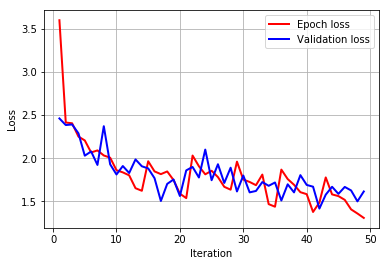

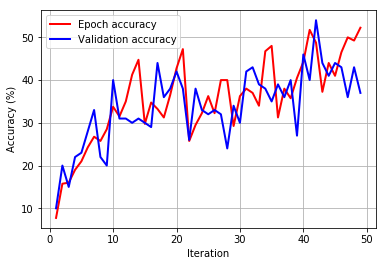

In [22]:
PlotResults(prune_settings)


# Training Routines

## Train Baseline Model

In [0]:
# Import data
dat = DatasetManager('cifar10', 1.0, 20.0)
dat.ImportDataset(5)

model_baseline.train()

model_baseline = train_model(model_baseline, dat, criterion, optimizer, exp_lr_scheduler, num_epochs=25)


## Train Pruned Model

In [0]:
# Import data
dat = DatasetManager('cifar10', 1.0, 20.0)
dat.ImportDataset(5)

model.train()

model = train_model(model, dat, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
